In [1]:
# ==========================================
# 🧱 Manipulação e análise de dados
# ==========================================
import pandas as pd
import numpy as np
import math

# ==========================================
# 📊 Visualização
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 🤖 Machine Learning
# ==========================================
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb


from google.cloud import bigquery
from google.cloud.aiplatform_v1 import (FeatureOnlineStoreAdminServiceClient,
                                        FeatureOnlineStoreServiceClient,
                                        FeatureRegistryServiceClient)
from google.cloud.aiplatform_v1.types import feature as feature_pb2
from google.cloud.aiplatform_v1.types import feature_group as feature_group_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store as feature_online_store_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store_admin_service as \
    feature_online_store_admin_service_pb2
from google.cloud.aiplatform_v1.types import \
    feature_online_store_service as feature_online_store_service_pb2
from google.cloud.aiplatform_v1.types import \
    feature_registry_service as feature_registry_service_pb2
from google.cloud.aiplatform_v1.types import feature_view as feature_view_pb2
from google.cloud.aiplatform_v1.types import \
    featurestore_service as featurestore_service_pb2
from google.cloud.aiplatform_v1.types import io as io_pb2


In [2]:
gcs_train_path = 'gs://road_accident/train.csv'
gcs_test_path = 'gs://road_accident/test.csv'

In [3]:
df_train_raw = pd.read_csv(gcs_train_path)
df_test_raw = pd.read_csv(gcs_test_path)

In [4]:
df_train = df_train_raw.copy()
df_train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [5]:
df_test = df_test_raw.copy()
df_test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [7]:
df_train.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


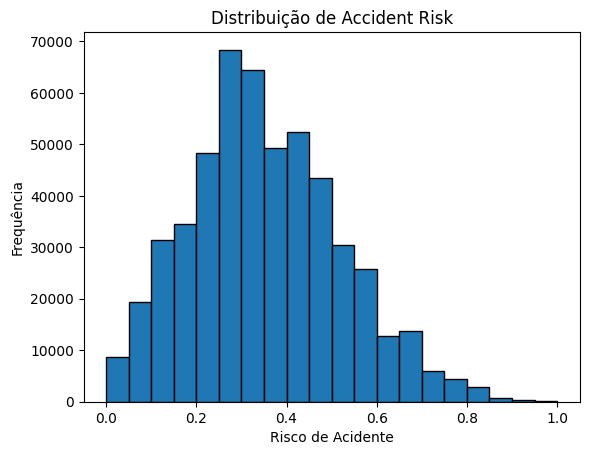

In [8]:
plt.hist(df_train['accident_risk'], bins=20, edgecolor='black')
plt.title('Distribuição de Accident Risk')
plt.xlabel('Risco de Acidente')
plt.ylabel('Frequência')
plt.show()

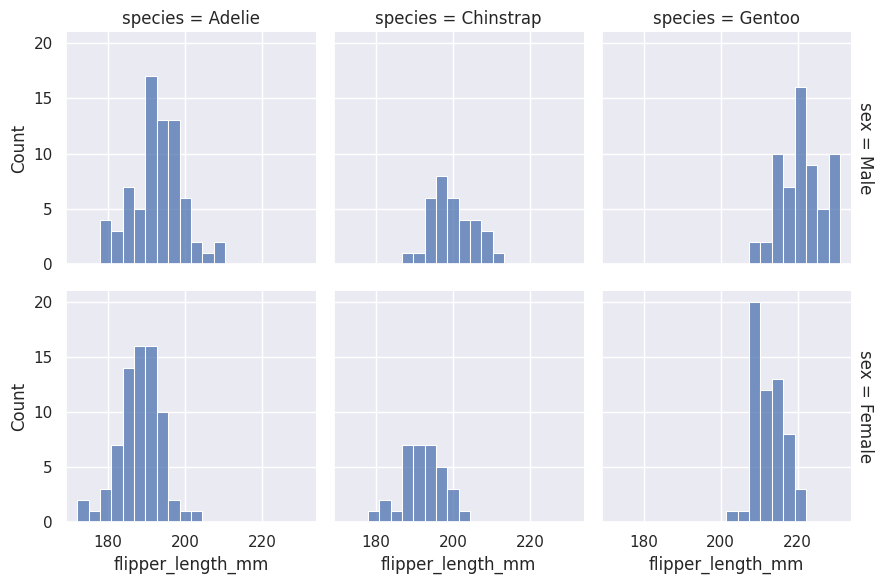

In [9]:


sns.set_theme(style="darkgrid")
df = sns.load_dataset("penguins")
sns.displot(
    df, x="flipper_length_mm", col="species", row="sex",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

In [10]:
categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 'holiday', 'school_season', 'public_road', 'road_signs_present']

for col in categorical_cols:
    print(f"\nDistribuição de {col}:")
    print(df_train[col].value_counts(normalize=True) * 100)


Distribuição de road_type:
road_type
highway    33.543343
rural      33.359279
urban      33.097378
Name: proportion, dtype: float64

Distribuição de lighting:
lighting
dim         35.504506
daylight    34.382158
night       30.113336
Name: proportion, dtype: float64

Distribuição de weather:
weather
foggy    35.048112
clear    34.631505
rainy    30.320384
Name: proportion, dtype: float64

Distribuição de time_of_day:
time_of_day
morning      33.492740
evening      33.382069
afternoon    33.125191
Name: proportion, dtype: float64

Distribuição de holiday:
holiday
True     50.34978
False    49.65022
Name: proportion, dtype: float64

Distribuição de school_season:
school_season
False    50.248574
True     49.751426
Name: proportion, dtype: float64

Distribuição de public_road:
public_road
True     50.22559
False    49.77441
Name: proportion, dtype: float64

Distribuição de road_signs_present:
road_signs_present
False    50.079574
True     49.920426
Name: proportion, dtype: float64


In [11]:
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('id')

In [12]:
numerical_cols

['num_lanes',
 'curvature',
 'speed_limit',
 'num_reported_accidents',
 'accident_risk']

In [13]:

def grid_hist_por_categorica(
    df,
    alvo: str,
    categorical_cols,
    bins: int = 20,
    ncols: int = 3,
    figsize_per_plot=(4, 3),   # largura, altura de cada subplot
    density: bool = True
):
    """
    Cria um grid (subplots) com um histograma por variável categórica.
    Em cada subplot, sobrepõe um histograma por classe da categórica.

    Parâmetros:
        df: DataFrame
        alvo: nome da coluna alvo (ex.: 'accident_risk')
        categorical_cols: lista de colunas categóricas
        bins: número de bins para o histograma
        ncols: nº de colunas do grid (linhas são calculadas automaticamente)
        figsize_per_plot: tupla com (largura, altura) de cada subplot
        density: True para normalizar (comparar formas), False para contagens
    """
    n = len(categorical_cols)
    nrows = math.ceil(n / ncols)

    # calcula tamanho total da figura a partir do tamanho por subplot
    fig_w = figsize_per_plot[0] * ncols
    fig_h = figsize_per_plot[1] * nrows
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, fig_h), squeeze=False)

    # limites globais do alvo para deixar os eixos comparáveis
    vals_alvo = df[alvo].dropna().values
    xmin = np.nanmin(vals_alvo)
    xmax = np.nanmax(vals_alvo)

    for i, col in enumerate(categorical_cols):
        r, c = divmod(i, ncols)
        ax = axes[r, c]

        # categorias válidas
        cats = df[col].dropna().unique()
        try:
            cats = sorted(cats, key=lambda x: str(x))
        except Exception:
            pass

        plotted_any = False
        for cat in cats:
            subset = df.loc[df[col] == cat, alvo].dropna().values
            if subset.size == 0:
                continue
            ax.hist(
                subset,
                bins=bins,
                density=density,
                alpha=0.45,
                edgecolor="black",
                label=str(cat)
            )
            plotted_any = True

        ax.set_title(col)
        ax.set_xlabel(alvo)
        ax.set_ylabel("Densidade" if density else "Contagem")
        ax.set_xlim(xmin, xmax)
        if plotted_any:
            ax.legend(frameon=False, fontsize=8)

    # apaga subplots sobrando
    total_slots = nrows * ncols
    for j in range(n, total_slots):
        r, c = divmod(j, ncols)
        fig.delaxes(axes[r, c])

    fig.suptitle(f"Distribuição de {alvo} por classes das variáveis categóricas", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()


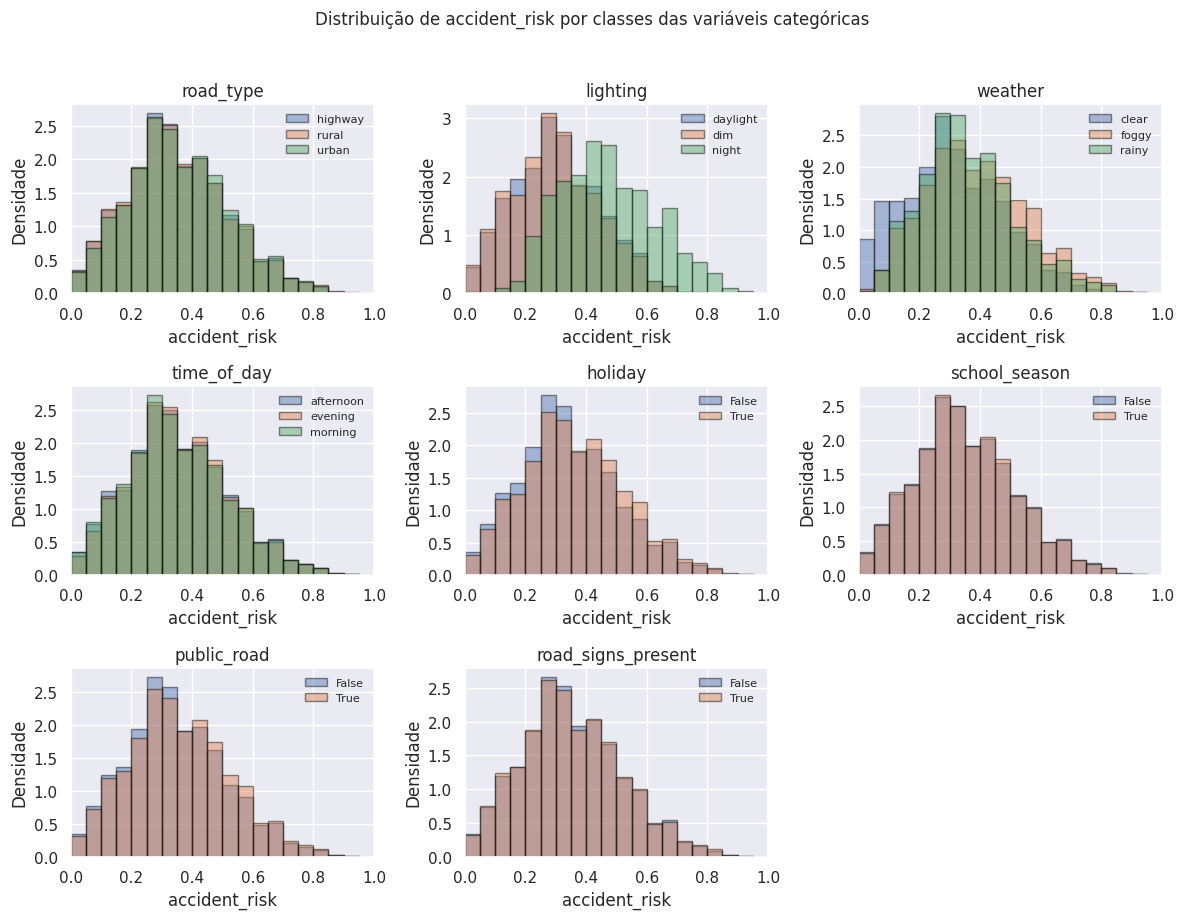

In [14]:
categorical_cols = ['road_type','lighting','weather','time_of_day',
                    'holiday','school_season','public_road','road_signs_present']

grid_hist_por_categorica(
    df=df_train,
    alvo='accident_risk',
    categorical_cols=categorical_cols,
    bins=20,
    ncols=3,                  # mude para 2 ou 4 se preferir
    figsize_per_plot=(4,3),   # ajuste o tamanho de cada subplot
    density=True
)



In [15]:


df = df_train.copy()




In [16]:
# Separar alvo
target = 'accident_risk'
X = df.drop(columns=[target])
y = df[target]

# Encode categóricas
categorical_cols = ['road_type','lighting','weather','time_of_day',
                    'holiday','school_season','public_road','road_signs_present']

le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Dividir treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_val.shape)

(414203, 13) (103551, 13)


In [17]:

# Modelo baseline
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Previsões
y_pred = xgb_model.predict(X_val)

# Avaliação
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 0.0564
MAE: 0.0438
R²: 0.8849


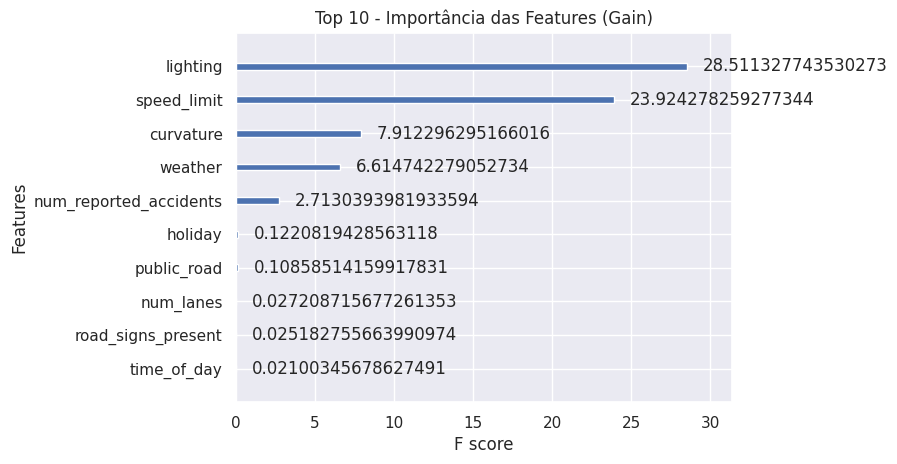

In [18]:
xgb.plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 - Importância das Features (Gain)")
plt.show()

In [19]:
# CRIADA A ONLINE STORE VIA CONSOLE (POSSÍVEL CRIAR VIA CÓDIGO)
# CRIADA A FEATURE VIEW VIA CONSOLE (POSSÍVEL CRIAR VIA CÓDIGO)


In [20]:
from google.cloud.aiplatform_v1 import (FeatureOnlineStoreAdminServiceClient,
                                        FeatureOnlineStoreServiceClient,
                                        FeatureRegistryServiceClient)

from google.cloud import aiplatform
from google.cloud import aiplatform_v1beta1 as aip

In [21]:
PROJECT_ID = 'vertexai-457414'
LOCATION = 'us-central1'
API_ENDPOINT = f"{LOCATION}-aiplatform.googleapis.com"

# SINCRONIZAR
FEATURE_ONLINE_STORE_ID = "feature_store_teste"
FEATURE_VIEW_ID = "view_teste"

In [22]:
admin_client = FeatureOnlineStoreAdminServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)
registry_client = FeatureRegistryServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

In [23]:
# LISTAGEM DE FEATURE VIEWS
admin_client.list_feature_views(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}"
)

ListFeatureViewsPager<feature_views {
  name: "projects/666534829864/locations/us-central1/featureOnlineStores/feature_store_teste/featureViews/view_teste"
  create_time {
    seconds: 1760631620
    nanos: 808291000
  }
  update_time {
    seconds: 1760631627
    nanos: 326130000
  }
  etag: "AMEw9yP1F19u82BHoL-nCUuyvBhLWSbwfBDE5J-Zav6qwta6h1MCsVC7qN5WIQHAApKW"
  big_query_source {
    uri: "bq://vertexai-457414.road_accident_feature_store.vw_road_accident"
    entity_id_columns: "road_type"
  }
}
>

In [24]:
admin_client.list_feature_view_syncs(
    parent=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

ListFeatureViewSyncsPager<feature_view_syncs {
  name: "projects/vertexai-457414/locations/us-central1/featureOnlineStores/feature_store_teste/featureViews/view_teste/featureViewSyncs/8908337530017939456"
  create_time {
    seconds: 1760647648
    nanos: 882474000
  }
  final_status {
  }
  run_time {
    start_time {
      seconds: 1760647648
      nanos: 882474000
    }
    end_time {
      seconds: 1760647716
      nanos: 186931000
    }
  }
}
feature_view_syncs {
  name: "projects/vertexai-457414/locations/us-central1/featureOnlineStores/feature_store_teste/featureViews/view_teste/featureViewSyncs/3999413936184098816"
  create_time {
    seconds: 1760647499
    nanos: 121272000
  }
  final_status {
  }
  run_time {
    start_time {
      seconds: 1760647499
      nanos: 121272000
    }
    end_time {
      seconds: 1760647566
      nanos: 455677000
    }
  }
}
feature_view_syncs {
  name: "projects/vertexai-457414/locations/us-central1/featureOnlineStores/feature_store_teste/featu

In [25]:
sync_response = admin_client.sync_feature_view(
    feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}"
)

In [26]:
import time
rodar = false
if rodar = True:
    while True:
        feature_view_sync = admin_client.get_feature_view_sync(
            name=sync_response.feature_view_sync
        )
        if feature_view_sync.run_time.end_time.seconds > 0:
            status = "Succeed" if feature_view_sync.final_status.code == 0 else "Failed"
            print(f"Sync {status} for {feature_view_sync.name}.")
            break
        else:
            print("Sync ongoing, waiting for 30 seconds.")
        time.sleep(10)

SyntaxError: invalid syntax (2732843248.py, line 3)

In [ ]:
print(sync_response)

In [ ]:
data_client = FeatureOnlineStoreServiceClient(
    client_options={"api_endpoint": API_ENDPOINT}
)

In [ ]:
data_client

In [ ]:
data_client.fetch_feature_values(
    request=feature_online_store_service_pb2.FetchFeatureValuesRequest(
        feature_view=f"projects/{PROJECT_ID}/locations/{LOCATION}/featureOnlineStores/{FEATURE_ONLINE_STORE_ID}/featureViews/{FEATURE_VIEW_ID}",
        data_key=feature_online_store_service_pb2.FeatureViewDataKey(key="highway"),
    )
)